In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'


path_figs = "./Figs/"

g_sequences = {}

g_sequences[0] = ['13524232514' ,'35421252143',  '51423252413', '14325242135'] #Group 1 sequences
g_sequences[1] = ['51423252413', '14325242135', '13524232514' ,'35421252143'] #Group 2 sequences

seq_length = len(g_sequences[0][0]) #Length of sequences

windowSizes = [2, 3, 4, 11]

digit_change = [4, 6, 8] #position of changed digit in changed sequence

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers


iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
precueTime = 0 # msecs for planning before movement 
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1, 2, 3, 5]

num_pre_train_blocks = 1
num_train_blocks = 6
num_post_train_blocks = 1

num_pre_test_blocks = 1
num_test_blocks = 4 * 4
num_post_test_blocks = 1


test_session2_blocks_nums = list(range(9, 9 + 1 + 2 * 4 + 1))

test_session3_blocks_nums = list(range(19, 19 + 1 + 2 * 4 + 1))


In [2]:
subjs_list = utils.read_dat_files_subjs_list(sub_nums)

In [2]:
# subjs_list = utils.read_dat_files_subjs_list(range(1,total_sub_num+1))

subjs_list = utils.read_dat_files_subjs_list(sub_nums)

# subjs_list = [utils.remove_error_trials(subj) for subj in subjs_list] ##Removing the error trials

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)

subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe
subjs.reset_index(inplace=True, drop=True)

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})


In [8]:
subjs_presses['is_trained_seq'] = subjs_presses.apply(utils.is_trained_seq, axis = 1)
subjs_presses['is_untrained_seq'] = subjs_presses.apply(utils.is_untrained_seq, axis = 1)
subjs_presses['is_rand_seq'] = subjs_presses.apply(utils.is_rand_seq, axis = 1)
subjs_presses['is_digit_changed'] = subjs_presses.apply(utils.is_digit_changed, axis = 1)


subjs['is_trained_seq'] = subjs.apply(utils.is_trained_seq, axis = 1)
subjs['is_untrained_seq'] = subjs.apply(utils.is_untrained_seq, axis = 1)
subjs['is_rand_seq'] = subjs.apply(utils.is_rand_seq, axis = 1)
subjs['is_digit_changed'] = subjs.apply(utils.is_digit_changed, axis = 1)


In [9]:
# rank_df = pd.DataFrame(index = subjs.index, dtype='int')
# for (subnum, seq, is_digit_changed), data in subjs.groupby(['SubNum', 'seq', 'is_digit_changed']):
#     data = data.sort_values(by = ['BN', 'TN'])
#     data['Rank'] = data.groupby(['BN', 'TN']).ngroup() + 1
#     rank_df.loc[data.index, 'Rank'] = data['Rank'].astype('int')
        

# subjs['Rank'] = rank_df['Rank'].astype('int')

In [18]:
# subjs.to_csv(utils.path_misc+'subjs.csv', index = False, sep = '\t')
# subjs_presses.to_csv(utils.path_misc+'subjs_presses.csv', index = False, sep = '\t')

In [17]:
# utils.remove_remaining_next_error_presses(subjs_presses)
# utils.remove_next_error_presses(subjs_presses)

## Sequence Specific Learning in Training:

TtestResult(statistic=1.1277876588050675, pvalue=0.34146047096105, df=3)
TtestResult(statistic=3.4726740153158846, pvalue=0.04026825662822943, df=3)


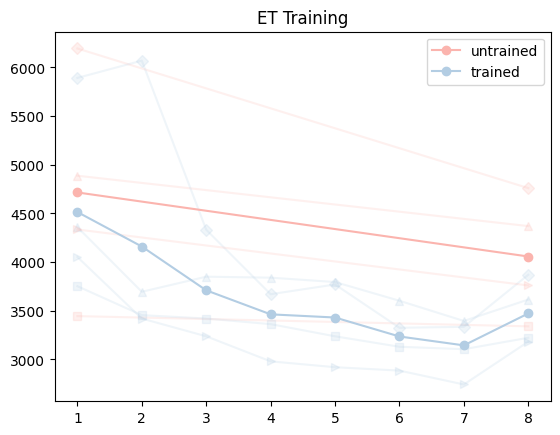

In [19]:
cmap = cm.Pastel1

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']

induction_blocks = subjs[subjs['BN'] <= num_pre_train_blocks+num_train_blocks+num_post_test_blocks]

induction_blocks = utils.remove_error_trials(induction_blocks)

induction_grouped = induction_blocks.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'norm_MT': 'median'
}).reset_index()


for subnum, subj_data in induction_grouped.groupby('SubNum'):
    for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
        plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(idx), alpha = 0.2)


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))        

induction_grouped = induction_grouped.groupby(['BN', 'is_trained_seq']).agg({
    'norm_MT': ['mean', 'std']
}).reset_index()
for idx, (flag, data) in enumerate(induction_grouped.groupby('is_trained_seq')):
    plt.plot(data['BN'], data['norm_MT']['mean'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))


plt.title('ET Training')

plt.legend()

plt.show()

TtestResult(statistic=1.1277876588050675, pvalue=0.34146047096105, df=3)
TtestResult(statistic=3.4726740153158846, pvalue=0.04026825662822943, df=3)


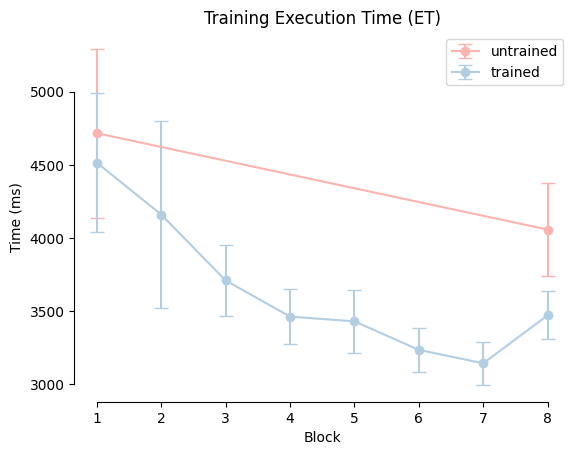

In [20]:
cmap = cm.Pastel1

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']

induction_blocks = subjs[subjs['BN'] <= num_pre_train_blocks+num_train_blocks+num_post_test_blocks]

induction_blocks = utils.remove_error_trials(induction_blocks)

induction_grouped = induction_blocks.groupby(['BN', 'SubNum', 'is_trained_seq']).agg({
    'norm_MT': 'median'
}).reset_index()


# for subnum, subj_data in induction_grouped.groupby('SubNum'):
#     for idx, (flag, data) in enumerate(subj_data.groupby('is_trained_seq')):
#         plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(idx), alpha = 0.2)


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 1) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))


print(stats.ttest_rel(induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == False)]['norm_MT'], 
                      induction_grouped[(induction_grouped['BN'] == 8) & (induction_grouped['is_trained_seq'] == True)]['norm_MT']))        

induction_grouped = induction_grouped.groupby(['BN', 'is_trained_seq']).agg({
    'norm_MT': ['mean', 'sem']
}).reset_index()
for idx, (flag, data) in enumerate(induction_grouped.groupby('is_trained_seq')):
    # plt.plot(data['BN'], data['norm_MT']['mean'], marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))
    plt.errorbar(data['BN'], data['norm_MT']['mean'], yerr=data['norm_MT']['sem'],  capsize= 5, marker = 'o', color = cmap(idx), label = (lambda x: 'trained' if x else 'untrained')(flag))


plt.title('Training Execution Time (ET)')
plt.ylabel('Time (ms)')
plt.xlabel('Block')

plt.legend()

sns.despine(trim=True)
# plt.savefig(path_figs + "Training.pdf", format = 'pdf')
plt.show()

## All Sessions Analysis:

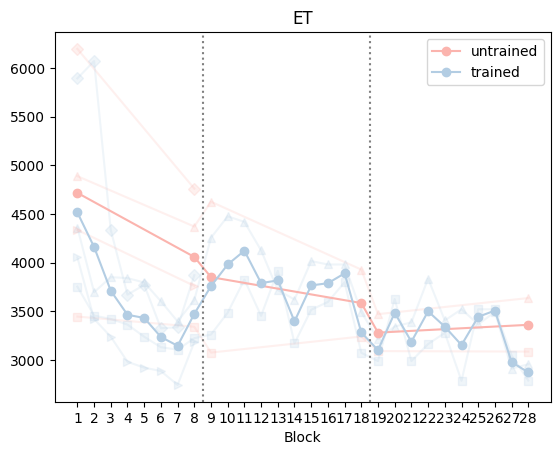

In [22]:
cmap = cm.Pastel1
test_blocks = subjs[subjs['BN'].isin(range(1,29))]

markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x', '_']


test_blocks = utils.remove_error_trials(test_blocks)

session_grouped = test_blocks.groupby(['BN', 'SubNum', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'median'
}).reset_index()

for subnum, subj_data in session_grouped.groupby('SubNum'):
    for idx, ((flag_trained, flag_untrained), data) in enumerate(subj_data.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(1), alpha = 0.2)
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = markers[subnum], color = cmap(0), alpha = 0.2)
            
        

session_grouped = session_grouped.groupby(['BN', 'is_trained_seq', 'is_untrained_seq', 'is_rand_seq']).agg({
    'norm_MT': 'mean'
}).reset_index()
for idx, ((flag_trained, flag_untrained), data) in enumerate(session_grouped.groupby(['is_trained_seq', 'is_untrained_seq'])):
        if (flag_trained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(1), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))
        if (flag_untrained == True):
            plt.plot(data['BN'], data['norm_MT'], marker = 'o', color = cmap(0), label = (lambda x: 'trained' if x else 'untrained')(flag_trained))

plt.axvline(x=8.5, color='gray', linestyle='dotted')

plt.axvline(x=18.5, color='gray', linestyle='dotted')

plt.xticks(range(1,29))


plt.title('ET')

plt.xlabel('Block')

plt.legend()

plt.show()

### Error Analysis:

In [23]:
print("whole experiment number of trials: ", len(subjs))

print("whole experiment error trials: ", len(subjs[subjs['isError'] == 1]))


test_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

print("\n \ntest blocks number of trials: ", len(test_blocks))
print("test blocks error trials: ", len(test_blocks[test_blocks['isError'] == 1]))

non_test_blocks = subjs[~subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]
print("non test blocks error trials: ", len(non_test_blocks[non_test_blocks['isError'] == 1]))




session1_blocks = subjs[subjs['BN'].isin(range(1,9))]
print("\n \nfirst sessions number of trials: ", len(session1_blocks))
print("first sessions error trials: ", len(session1_blocks[session1_blocks['isError'] == 1]))

session2_blocks = subjs[subjs['BN'].isin(range(9, 19))]
print("\n\nsecond session number of trials: ", len(session2_blocks))
print("second session error trials: ", len(session2_blocks[session2_blocks['isError'] == 1]))


session2_pre_post = subjs[subjs['BN'].isin([9,18])]
session3_pre_post = subjs[subjs['BN'].isin([19,28])]
print("\n \nsecond sessions error trials in pre and post: ", len(session2_pre_post[session2_pre_post['isError'] == 1]))
print("\n \nthird sessions error trials in pre and post: ", len(session3_pre_post[session3_pre_post['isError'] == 1]))


whole experiment number of trials:  2240
whole experiment error trials:  428

 
test blocks number of trials:  960
test blocks error trials:  199
non test blocks error trials:  229

 
first sessions number of trials:  1024
first sessions error trials:  196


second session number of trials:  608
second session error trials:  110

 
second sessions error trials in pre and post:  12

 
third sessions error trials in pre and post:  21


In [24]:
test_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

print("test blocks number of trials: ", len(test_blocks))

subjs_test_error = test_blocks[test_blocks['isError'] == 1]

print("test blocks number of errors: ", len(subjs_test_error))


for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):
                for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                        print(f"digit {digit+1} : {len(digit_presses)}")


        if (flag_trained & ~flag_change):
                print(f"unchanged: {len(data)}")


        if (flag_rand):
                print(f"rand: {len(data)}")



test blocks number of trials:  960
test blocks number of errors:  199
rand: 115
unchanged: 27
digit 5 : 13
digit 7 : 21
digit 9 : 23


seems like they are making more errors in changed compared to the previous experiment (changing only one digit)

error median:  310.0
non error median:  300.0


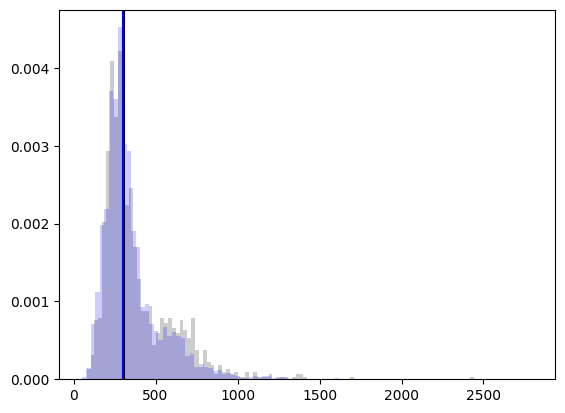

In [25]:
test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

test_blocks_error = test_blocks[test_blocks['isTrialError'] == 1]

test_blocks_error = utils.remove_remaining_next_error_presses(test_blocks_error)

test_blocks_non_error = utils.remove_error_trials_presses(test_blocks)


plt.hist(test_blocks_error['IPI_Value'], density=True, bins=100, alpha = 0.2, color = 'black')
plt.axvline(test_blocks_error['IPI_Value'].median(), color ='black', label = 'error')
print("error median: ", test_blocks_error['IPI_Value'].median())

plt.hist(test_blocks_non_error['IPI_Value'], density=True, bins = 100, alpha = 0.2, color = 'blue')
plt.axvline(test_blocks_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
print("non error median: ", test_blocks_non_error['IPI_Value'].median())


plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


error median:  267.5
non error median:  475.0
error median:  222.5
non error median:  260.0
error median:  287.5
non error median:  280.0
error median:  225.0
non error median:  255.0


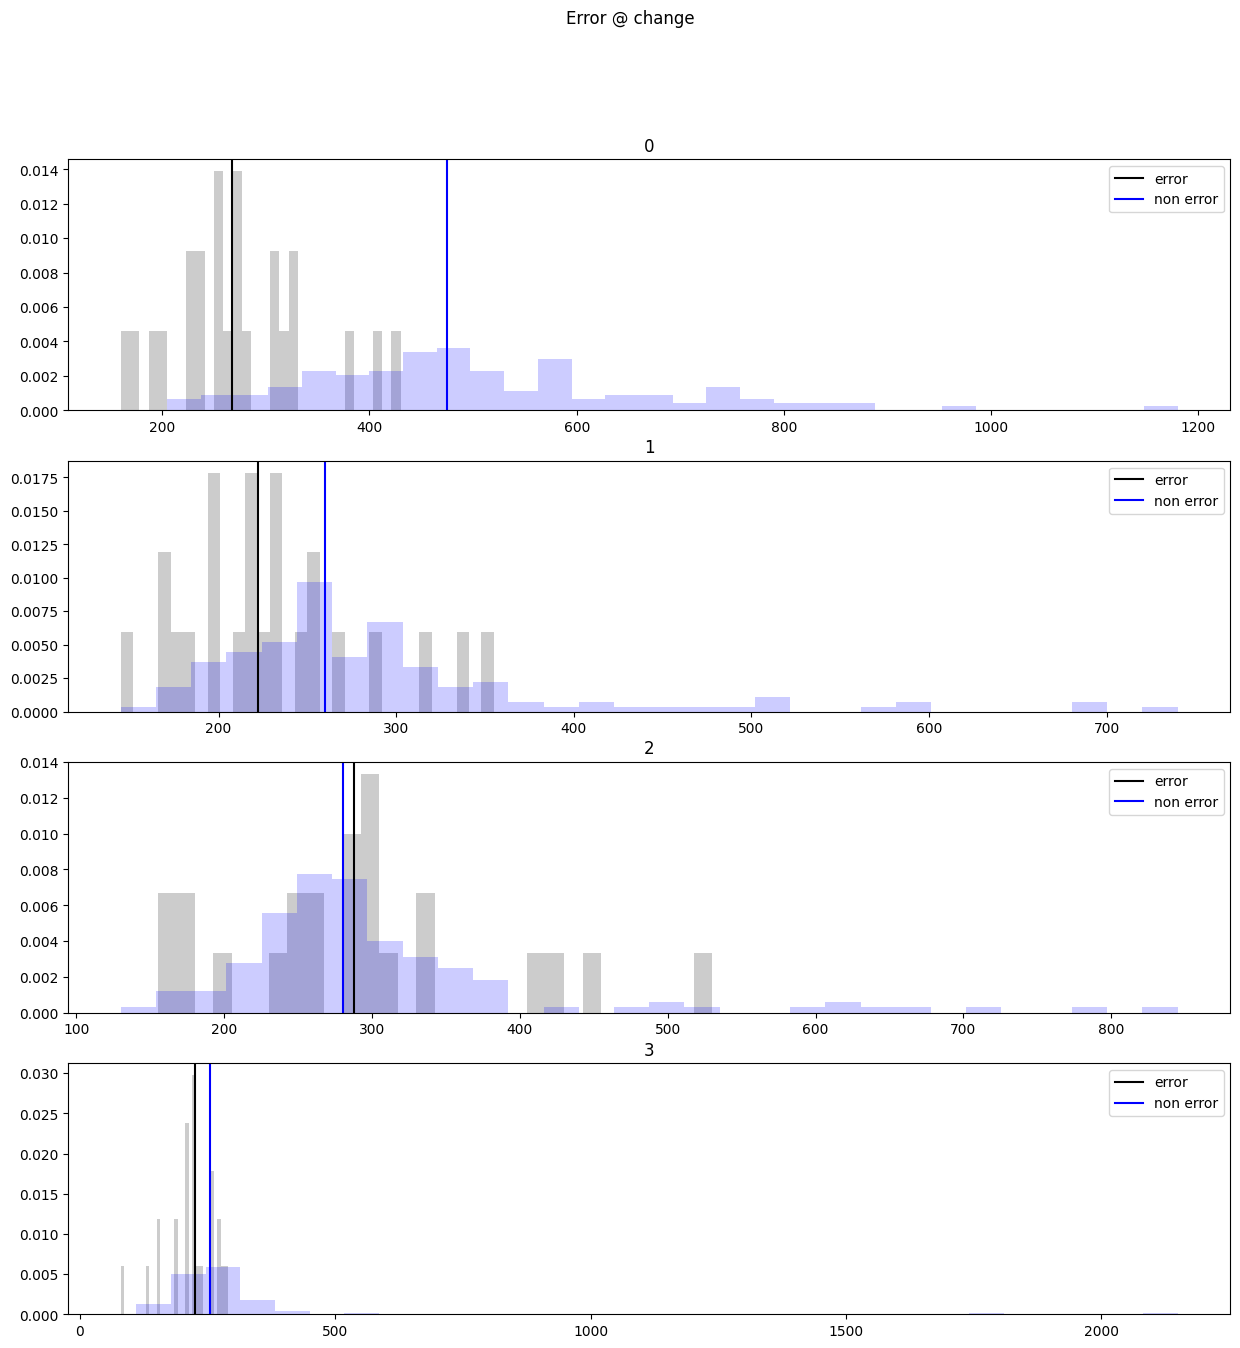

In [26]:
lookback_window = 4
fig, axs = plt.subplots(nrows=lookback_window , figsize= (15,15))

test_blocks_changed = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

test_blocks_changed = test_blocks_changed[(test_blocks_changed['is_trained_seq']) & (test_blocks_changed['is_digit_changed'])]

test_blocks_error = test_blocks_changed[test_blocks_changed['isTrialError'] == 1] 

test_blocks_error = utils.remove_remaining_next_error_presses(test_blocks_error)
# # test_blocks_error = test_blocks_error[test_blocks_error['isPressError'] == 1]

test_blocks_non_error = utils.remove_error_trials_presses(test_blocks_changed)

error_in_changed = test_blocks_error[test_blocks_error['N'] == (test_blocks_error['digitChangePos'] + 1)]
condition_rows = error_in_changed[error_in_changed['isPressError'] == 1][['SubNum','BN','TN']].drop_duplicates()
test_blocks_error = test_blocks_error.merge(condition_rows, on = ['SubNum', 'BN', 'TN'], how = 'inner')

for lookback in range(lookback_window):
    data_error = test_blocks_error[test_blocks_error['N'] == (test_blocks_error['digitChangePos'] + 1 - lookback)]
    data_non_error = test_blocks_non_error[test_blocks_non_error['N'] == (test_blocks_non_error['digitChangePos'] + 1 - lookback)]
    axs[lookback].hist(data_error['IPI_Value'],density=True, bins=30, alpha = 0.2, color = 'black' )
    axs[lookback].axvline(data_error['IPI_Value'].median(), color ='black', label = 'error')
    print("error median: ", data_error['IPI_Value'].median())

    axs[lookback].hist(data_non_error['IPI_Value'], density=True, bins = 30, alpha = 0.2, color = 'blue')
    axs[lookback].axvline(data_non_error['IPI_Value'].median(), color = 'blue', label = 'non error')
    print("non error median: ", data_non_error['IPI_Value'].median())
    axs[lookback].legend()
    axs[lookback].set_title(lookback)


fig.suptitle('Error @ change')
plt.show()

# sns.histplot(test_blocks_error['IPI_Value'], color='blue', kde = True)

# sns.histplot(test_blocks_non_error['IPI_Value'], color= 'yellow', kde = True)


rand: 115
unchanged: 27
digit 5 : 13
digit 7 : 21
digit 9 : 23


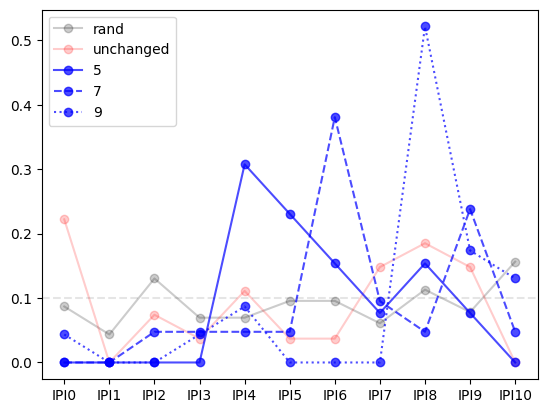

In [27]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

test_blocks = utils.remove_remaining_next_error_presses(test_blocks)

subjs_presses_test_error = test_blocks[test_blocks['isPressError'] == 1]

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_presses_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):
                for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                        print(f"digit {digit+1} : {len(digit_presses)}")
                        proportions = digit_presses['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        plt.plot(proportions.index.values, proportions, color = 'blue', label = digit+1, marker = 'o', alpha = 0.7, linestyle = line_styles[idx])

        if (flag_trained & ~flag_change):
                print(f"unchanged: {len(data)}")
                proportions = data['IPI_Number'].value_counts(sort=False)
                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                proportions /= sum(proportions)
                plt.plot(proportions.index.values, proportions, color = 'red', label = 'unchanged', marker = 'o', alpha = 0.2)

        if (flag_rand):
                print(f"rand: {len(data)}")
                proportions = data['IPI_Number'].value_counts(sort=False)
                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                proportions /= sum(proportions)
                plt.plot(proportions.index.values, proportions, color = 'black', label = 'rand', marker = 'o', alpha = 0.2)

plt.axhline(y = 0.1, color = 'black', linestyle = '--', alpha = 0.1)

plt.legend()
plt.show()

**************** 
 window 2 
 **************
rand: 23
unchanged: 4
digit 5 : 3
digit 7 : 5
digit 9 : 8
**************** 
 window 3 
 **************
rand: 32
unchanged: 9
digit 5 : 4
digit 7 : 5
digit 9 : 3
**************** 
 window 4 
 **************
rand: 25
unchanged: 5
digit 5 : 2
digit 7 : 6
digit 9 : 8
**************** 
 window 11 
 **************
rand: 35
unchanged: 9
digit 5 : 4
digit 7 : 5
digit 9 : 4


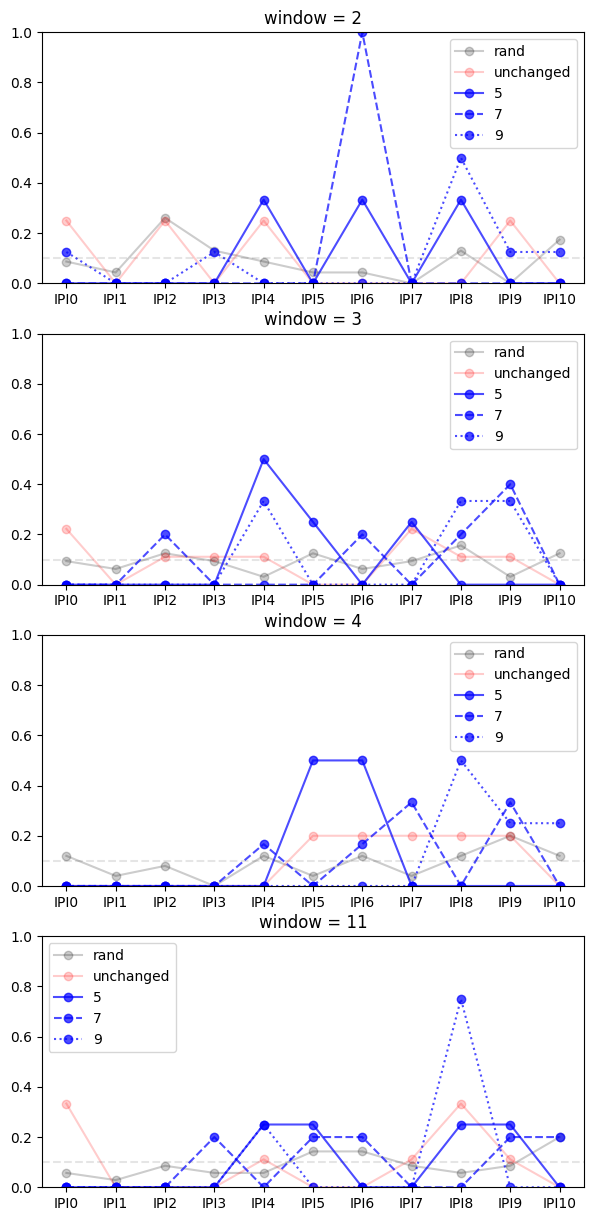

In [28]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']


fig, axs = plt.subplots(len(windowSizes), 1, figsize = (7,15))

for i, window in enumerate(windowSizes):
        print(f"**************** \n window {window} \n **************")

        test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

        test_blocks = test_blocks[test_blocks['windowSize'] == window]

        test_blocks = utils.remove_remaining_next_error_presses(test_blocks)


        subjs_presses_test_error = test_blocks[test_blocks['isPressError'] == 1]

        for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_presses_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
                if (flag_trained & flag_change):
                        for idx, (digit, digit_presses) in enumerate(data.groupby('digitChangePos')):
                                print(f"digit {digit+1} : {len(digit_presses)}")
                                proportions = digit_presses['IPI_Number'].value_counts(sort=False)
                                proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                                proportions /= sum(proportions)
                                axs[i].plot(proportions.index.values, proportions, color = 'blue', label = digit+1, marker = 'o', alpha = 0.7, linestyle = line_styles[idx])

                if (flag_trained & ~flag_change):
                        print(f"unchanged: {len(data)}")
                        proportions = data['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        axs[i].plot(proportions.index.values, proportions, color = 'red', label = 'unchanged', marker = 'o', alpha = 0.2)

                if (flag_rand):
                        print(f"rand: {len(data)}")
                        proportions = data['IPI_Number'].value_counts(sort=False)
                        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(0, seq_length)], fill_value = 0)
                        proportions /= sum(proportions)
                        axs[i].plot(proportions.index.values, proportions, color = 'black', label = 'rand', marker = 'o', alpha = 0.2)

        axs[i].axhline(y = 0.1, color = 'black', linestyle = '--', alpha = 0.1)
        axs[i].legend()
        axs[i].set_ylim([0,1])
        axs[i].set_title(f'window = {window}')
plt.show()

In [29]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']
markers = ['.', '>', 'o', '^']

lookback_window = 4


# fig, axs = plt.subplots(len(windowSizes), 1, figsize = (7,15))

for i, window in enumerate(windowSizes):
        print(f"**************** \n window {window} \n **************")
        test_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]
        test_blocks = test_blocks[test_blocks['windowSize'] == window]
        print(len(test_blocks[test_blocks['isError'] == 1]))



**************** 
 window 2 
 **************
43
**************** 
 window 3 
 **************
53
**************** 
 window 4 
 **************
46
**************** 
 window 11 
 **************
57


**************** 
 window 2 
 **************
changed: 10
dist_to_change
-3     0
-2     0
-1     0
0     10
Name: count, dtype: int64
**************** 
 window 3 
 **************
changed: 4
dist_to_change
-3    0
-2    0
-1    0
0     4
Name: count, dtype: int64
**************** 
 window 4 
 **************
changed: 6
dist_to_change
-3    0
-2    1
-1    0
0     5
Name: count, dtype: int64
**************** 
 window 11 
 **************
changed: 7
dist_to_change
-3    1
-2    0
-1    1
0     5
Name: count, dtype: int64


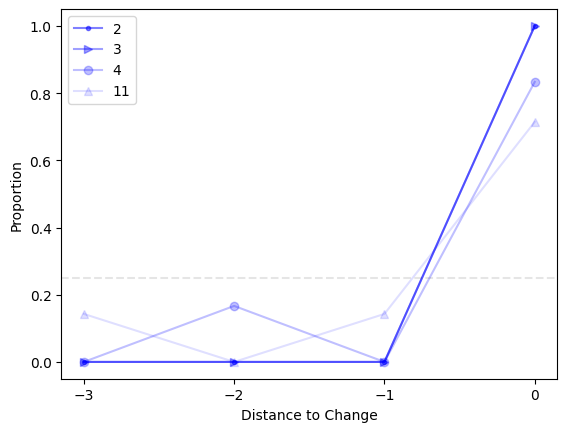

In [30]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']
markers = ['.', '>', 'o', '^']

lookback_window = 4


# fig, axs = plt.subplots(len(windowSizes), 1, figsize = (7,15))

for i, window in enumerate(windowSizes):
        print(f"**************** \n window {window} \n **************")

        test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

        test_blocks = test_blocks[test_blocks['windowSize'] == window]

        test_blocks = utils.remove_remaining_next_error_presses(test_blocks)

        subjs_presses_test_error = test_blocks[test_blocks['isPressError'] == 1]

        for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(subjs_presses_test_error.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
                if (flag_trained & flag_change):
                        data['dist_to_change'] = (data['N'] - 1 - data['digitChangePos'])
                        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, 1))]
                        print(f"changed: {len(data)}")
                        proportions = data['dist_to_change'].value_counts(sort = False)
                        proportions = proportions.reindex(range(-1 * lookback_window + 1, 1), fill_value = 0)
                        print(proportions)
                        proportions /= sum(proportions)
                        plt.plot(proportions.index.values, proportions, color = 'blue', label = f'{window}', marker = markers[i], alpha = (len(windowSizes) - i) / (2 * len(windowSizes)))
                        epsilon = 0.15
                        # plt.plot(proportions.index.values - epsilon * i + 0.3, proportions, color = 'blue', label = f'{window}', marker = markers[i], alpha = 0.1, linestyle='')


plt.axhline(y = 0.25, color = 'black', linestyle = '--', alpha = 0.1)
plt.xticks(proportions.index.values)
plt.xlabel('Distance to Change')
plt.ylabel('Proportion')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
# plt.legend()
plt.show()

IPI Analysis:

/Users/amin/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Text(0.5, 1.0, 'changed vs unchanged')

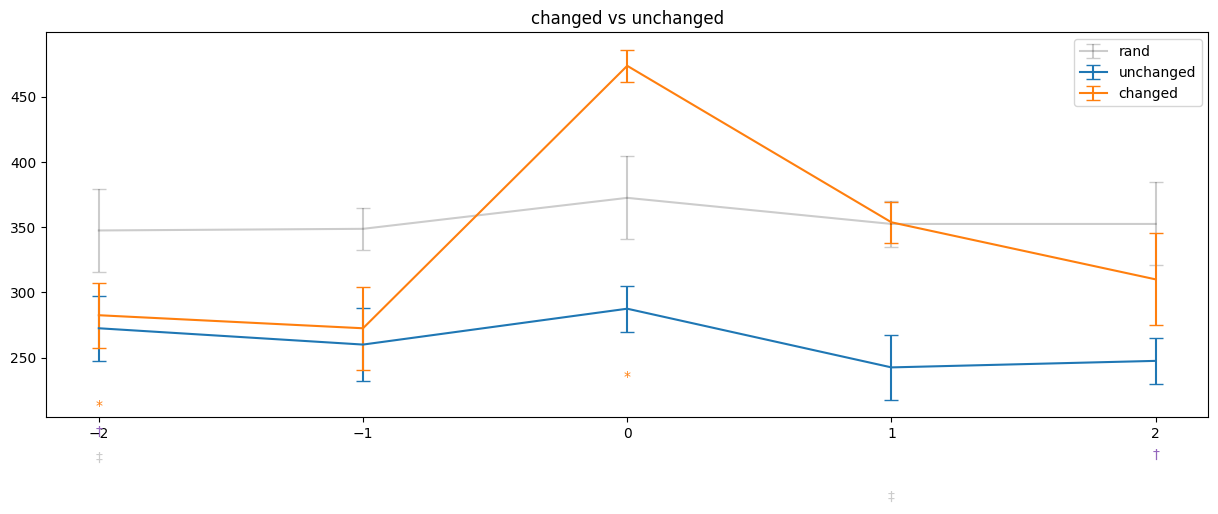

In [32]:
plt.figure(figsize=(15, 5))
cmap = cm.Pastel1
capsize = 5

lookback_window = 3

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials_presses(session3_blocks)

finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    if (flag_trained & flag_change):
        data['dist_to_change'] = (data['N'] - 1 - data['digitChangePos']) 
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
        label = 'changed'

    if (flag_trained & ~flag_change):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'unchanged'

    if (flag_rand):
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = (data['N'] - 1 - digitpos) 
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        data = pd.concat(list(datas.values()), ignore_index=True)
        label = 'rand'


    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    finger_aggs[label] = data

    finger_agg = data.groupby(['dist_to_change']).agg({
        'IPI_Value': ['mean', 'std']
    }).reset_index()

    finger_agg = finger_agg.iloc[index_natsorted(finger_agg['dist_to_change'])].reset_index(drop=True)
    plt.errorbar(finger_agg['dist_to_change'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = label, capsize = capsize, **kwargs[label])
    plt.xticks(finger_agg['dist_to_change'])



#Statistical Signficance Tests
merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'dist_to_change'], suffixes=('_changed', '_unchanged'))
merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'dist_to_change'])
merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

for IPI in merged_df['dist_to_change'].unique():
    IPI_data = merged_df[merged_df['dist_to_change'] == IPI]
    ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
    ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
    ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
    
    # Add significance symbols just above the error bars
    changed_mean = IPI_data['IPI_Value_changed'].mean()
    changed_std = IPI_data['IPI_Value_changed'].std()
    unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
    unchanged_std = IPI_data['IPI_Value_unchanged'].std()
    rand_mean = IPI_data['IPI_Value_rand'].mean()
    rand_std = IPI_data['IPI_Value_rand'].std()

    y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
    y_pos_unchanged = unchanged_mean - unchanged_std 
    y_pos_rand = rand_mean - rand_std

    y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

    if ttest_changed_vs_unchanged.pvalue < 0.05:
        plt.text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

    if ttest_changed_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

    if ttest_unchanged_vs_rand.pvalue < 0.05:
        plt.text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)




plt.legend(loc = 'upper right')

plt.title(f'changed vs unchanged')

/Users/amin/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/amin/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/amin/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


IPI:  IPI0 TtestResult(statistic=-2.709090909090909, pvalue=0.22511656811390968, df=1)
IPI:  IPI1 TtestResult(statistic=-5.5, pvalue=0.11449829409740034, df=1)
IPI:  IPI10 TtestResult(statistic=-7.0, pvalue=0.0903344706017331, df=1)
IPI:  IPI2 TtestResult(statistic=-inf, pvalue=0.0, df=1)
IPI:  IPI3 TtestResult(statistic=-5.8, pvalue=0.10869341146452537, df=1)
IPI:  IPI4 TtestResult(statistic=-29.0, pvalue=0.02194371123202196, df=1)
IPI:  IPI5 TtestResult(statistic=-16.2, pvalue=0.039247717598787625, df=1)
IPI:  IPI6 TtestResult(statistic=-18.0, pvalue=0.03533144577626927, df=1)
IPI:  IPI7 TtestResult(statistic=-14.6, pvalue=0.04353609848963751, df=1)
IPI:  IPI8 TtestResult(statistic=-3.3636363636363638, pvalue=0.1839674597292961, df=1)
IPI:  IPI9 TtestResult(statistic=-61.0, pvalue=0.010435454952617553, df=1)


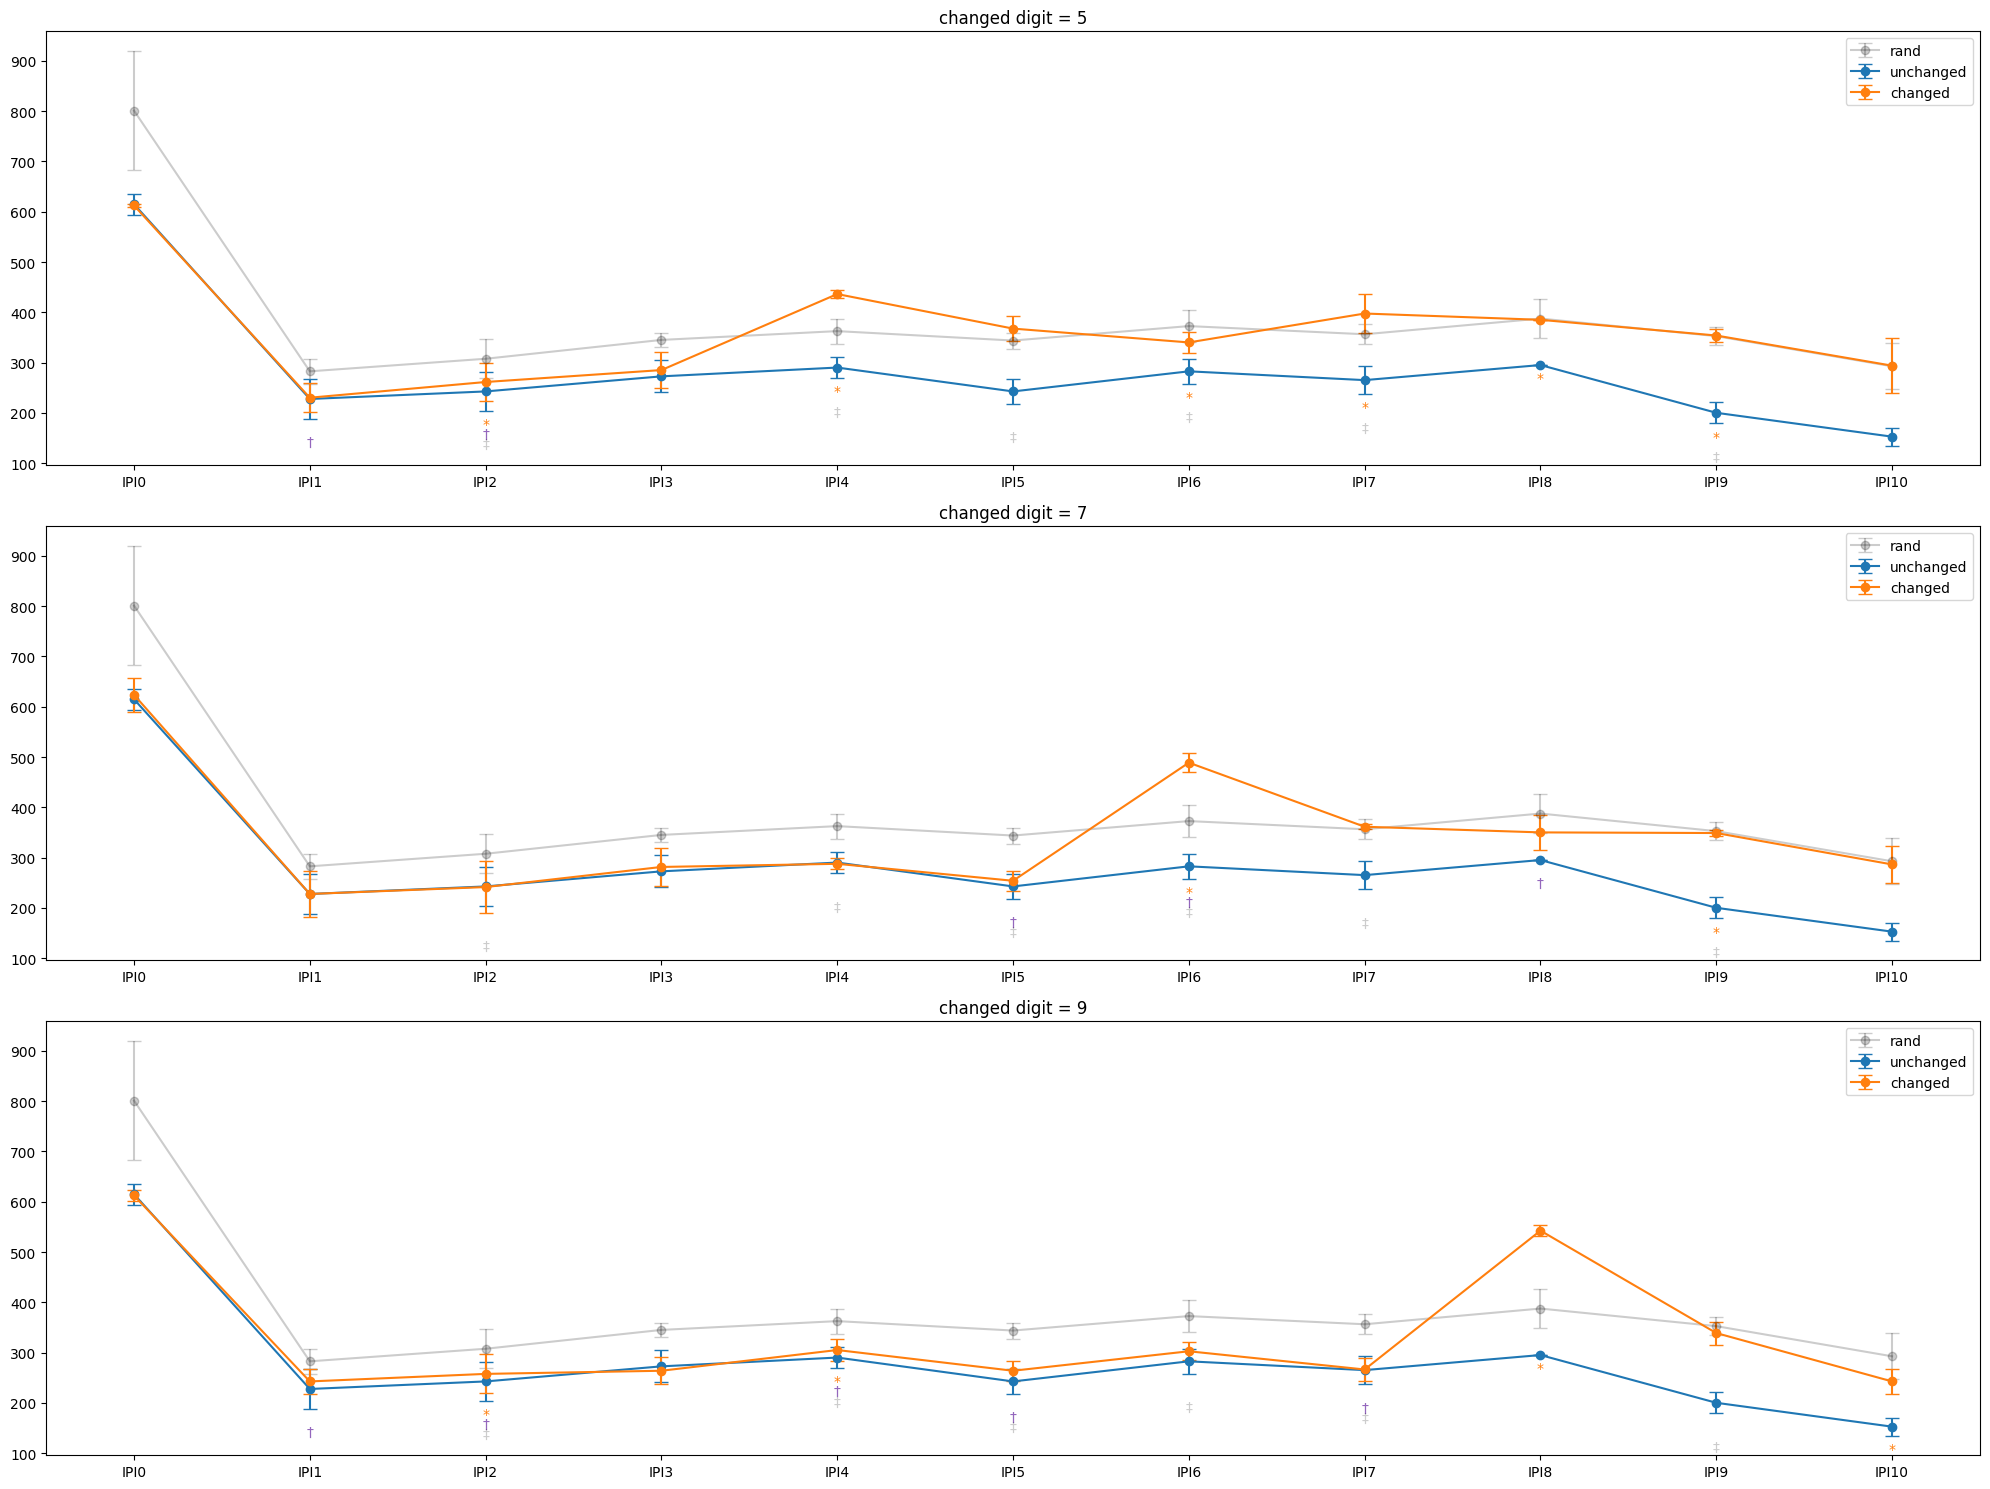

In [35]:
fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


session3_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials_presses(session3_blocks)

finger_aggs = {}

for idx, change in enumerate(digit_change):
    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
        if (flag_trained & flag_change):

            data = data[data['digitChangePos'] == change]

            label = 'changed'

        if (flag_trained & ~flag_change):

            label = 'unchanged'

        if (flag_rand):

            label = 'rand'


        data = data.groupby(['SubNum', 'IPI_Number']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data

        finger_agg = data.groupby(['IPI_Number']).agg({
            'IPI_Value': ['mean', 'std']
        }).reset_index()

        finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
        axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], 
                          label = label, capsize = capsize, **kwargs[label], fmt = '-o')



    #Statistical Signficance Tests
    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'IPI_Number'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})

    for IPI in merged_df['IPI_Number'].unique():
        IPI_data = merged_df[merged_df['IPI_Number'] == IPI]
        ttest_changed_vs_unchanged = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_unchanged'])
        ttest_changed_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_changed'], IPI_data['IPI_Value_rand'])
        ttest_unchanged_vs_rand = stats.ttest_rel(IPI_data['IPI_Value_unchanged'], IPI_data['IPI_Value_rand'])
        
        # Add significance symbols just above the error bars
        changed_mean = IPI_data['IPI_Value_changed'].mean()
        changed_std = IPI_data['IPI_Value_changed'].std()
        unchanged_mean = IPI_data['IPI_Value_unchanged'].mean()
        unchanged_std = IPI_data['IPI_Value_unchanged'].std()
        rand_mean = IPI_data['IPI_Value_rand'].mean()
        rand_std = IPI_data['IPI_Value_rand'].std()

        y_pos_changed = changed_mean - changed_std  # Adjust to place the asterisks above the error bars
        y_pos_unchanged = unchanged_mean - unchanged_std 
        y_pos_rand = rand_mean - rand_std

        y_pos = min(y_pos_changed, y_pos_rand, y_pos_unchanged)

        if ttest_changed_vs_unchanged.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 40, '*', ha='center', va='bottom', color='C1')

        if ttest_changed_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 60, '†', ha='center', va='bottom', color='C4')

        if ttest_unchanged_vs_rand.pvalue < 0.05:
            axs[idx].text(IPI, y_pos - 80, '‡', ha='center', va='bottom', color='black', alpha = 0.2)


        if(change == 6):
            print('IPI: ', IPI, ttest_unchanged_vs_rand)



    
    axs[idx].legend()

    axs[idx].set_title(f'changed digit = {change + 1}')
    plt.tight_layout()

    # plt.savefig(path_figs + "IPI_Pattern_Main.pdf", format = 'pdf')
    

rand  3 vs 11: p_value =  0.5843849263176828
unchanged  3 vs 11: p_value =  0.6559582607547387
changed  3 vs 11: p_value =  0.02194371123202196
All Three: 
                       Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition             9.5230 2.0000 2.0000 0.0950
windowSize           13.7718 3.0000 3.0000 0.0293
condition:windowSize  6.5050 6.0000 6.0000 0.0192

unchanged_rand: 
                       Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition            10.5213 1.0000 1.0000 0.1904
windowSize            7.8670 3.0000 3.0000 0.0621
condition:windowSize 10.0437 3.0000 3.0000 0.0450

changed_unchanged: 
                       Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition             0.3906 1.0000 1.0000 0.6444
windowSize           25.2710 3.0000 3.0000 0.0125
condition:windowSi

/Users/amin/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


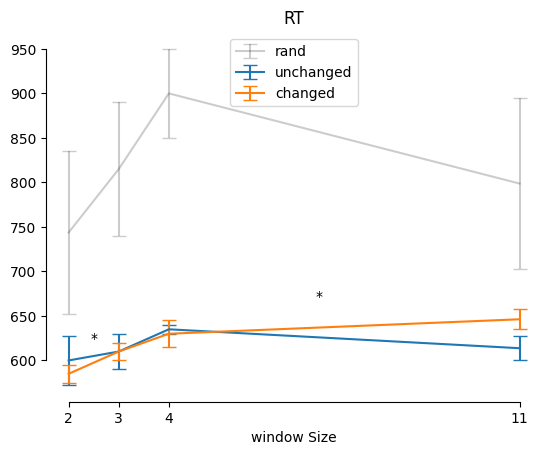

In [36]:
session3_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials(session3_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'RT': lambda x: np.percentile(x, 50)
    }).reset_index()

    finger_aggs[label] = data

        
    data_agged = data.groupby('windowSize').agg({
        'RT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['RT']['mean'], yerr = data_agged['RT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['RT']['mean']
    sems = data_agged['RT']['sem']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['RT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['RT'], 
        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


    t_stat, p_value = stats.ttest_rel(
        data[data['windowSize'] == 3]['RT'], 
        data[data['windowSize'] == 11]['RT']
    )
    print(label, " 3 vs 11: p_value = ",  p_value)
    if p_value < 0.05:
            plt.text((3 + 11) / 2, max(means[1] + sems[1], means[3] + sems[3]) + 10, '*', color='black', ha='center')


    
# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='RT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='RT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='RT', subject='SubNum', within=['condition', 'windowSize']).fit())





plt.xticks(data_agged['windowSize'])
plt.title('RT')
plt.legend()
plt.xlabel('window Size')
sns.despine(trim = True)
# plt.savefig(path_figs + "RT.pdf", format = 'pdf')
plt.show()




rand  3 vs 11: p_value =  0.8972654139381862
unchanged  3 vs 11: p_value =  0.457621390730107
changed  3 vs 11: p_value =  0.9072900935107433
All Three: 
                       Anova
                     F Value  Num DF Den DF Pr > F
--------------------------------------------------
condition            160.8789 2.0000 2.0000 0.0062
windowSize            10.9957 3.0000 3.0000 0.0398
condition:windowSize   0.9523 6.0000 6.0000 0.5229

unchanged_rand: 
                       Anova
                     F Value  Num DF Den DF Pr > F
--------------------------------------------------
condition            161.6322 1.0000 1.0000 0.0500
windowSize            21.9606 3.0000 3.0000 0.0152
condition:windowSize   0.7919 3.0000 3.0000 0.5738

changed_unchanged: 
                       Anova
                     F Value  Num DF Den DF Pr > F
--------------------------------------------------
condition            156.7757 1.0000 1.0000 0.0507
windowSize             2.8257 3.0000 3.0000 0.2082
condit

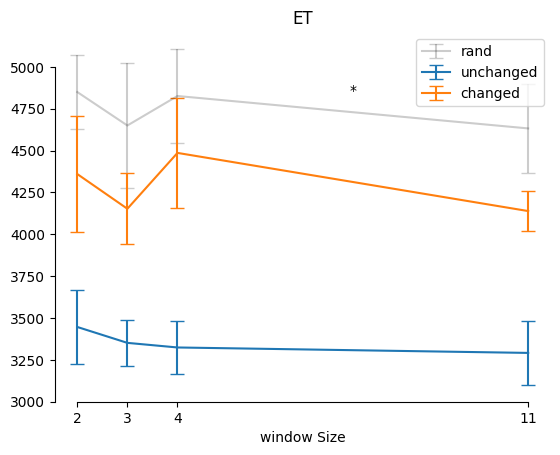

In [37]:
session3_blocks = subjs[subjs['BN'].isin(list(range(10,18)) + list(range(20,28)))]

session3_blocks = utils.remove_error_trials(session3_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


finger_aggs = {}

for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(session3_blocks.groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

    if (flag_trained & flag_change):
        label = 'changed'

    if(flag_trained & ~flag_change):
        label = 'unchanged'

    if (flag_rand):
        label = 'rand'

    data = data.groupby(['SubNum', 'windowSize']).agg({
    'norm_MT': lambda x: np.percentile(x, 50)
    }).reset_index()

    finger_aggs[label] = data

        
    data_agged = data.groupby('windowSize').agg({
        'norm_MT': ['mean', 'sem']
    }).reset_index()

    plt.errorbar(data_agged['windowSize'], data_agged['norm_MT']['mean'], yerr = data_agged['norm_MT']['sem'], label = label, capsize=5, **kwargs[label])

    means = data_agged['norm_MT']['mean']
    sems = data_agged['norm_MT']['sem']

    for i in range(len(windowSizes) - 1):
        t_stat, p_value = stats.ttest_rel(
            data[data['windowSize'] == windowSizes[i]]['norm_MT'], 
            data[data['windowSize'] == windowSizes[i + 1]]['norm_MT'], 
        )
        if p_value < 0.05:
            # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
            plt.text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
            # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


    t_stat, p_value = stats.ttest_rel(
        data[data['windowSize'] == 3]['norm_MT'], 
        data[data['windowSize'] == 11]['norm_MT']
    )
    print(label, " 3 vs 11: p_value = ",  p_value)
    if p_value < 0.05:
            plt.text((3 + 11) / 2, max(means[1] + sems[1], means[3] + sems[3]) + 10, '*', color='black', ha='center')


    
# Combine all data into a single DataFrame
combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                           finger_aggs['unchanged'].assign(condition='unchanged'),
                           finger_aggs['rand'].assign(condition='rand')])

print("All Three: \n", AnovaRM(data=combined_data, depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())
print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='norm_MT', subject='SubNum', within=['condition', 'windowSize']).fit())





plt.xticks(data_agged['windowSize'])
plt.title('ET')
plt.legend()
plt.xlabel('window Size')
sns.despine(trim = True)
# plt.savefig(path_figs + "ET.pdf", format = 'pdf')
plt.show()




************************** IPI Change + 0 **************************************
All Three: 
                       Anova
                     F Value  Num DF Den DF Pr > F
--------------------------------------------------
condition            338.4208 2.0000 2.0000 0.0029
windowSize            15.1744 3.0000 3.0000 0.0256
condition:windowSize   2.5279 6.0000 6.0000 0.1419

unchanged_rand: 
                       Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition            68.0625 1.0000 1.0000 0.0768
windowSize            2.4907 3.0000 3.0000 0.2366
condition:windowSize  1.8067 3.0000 3.0000 0.3196

changed_unchanged: 
                       Anova
                     F Value  Num DF Den DF Pr > F
--------------------------------------------------
condition            967.5374 1.0000 1.0000 0.0205
windowSize             6.6705 3.0000 3.0000 0.0767
condition:windowSize   4.2432 3.0000 3.0000 0.1330

********************

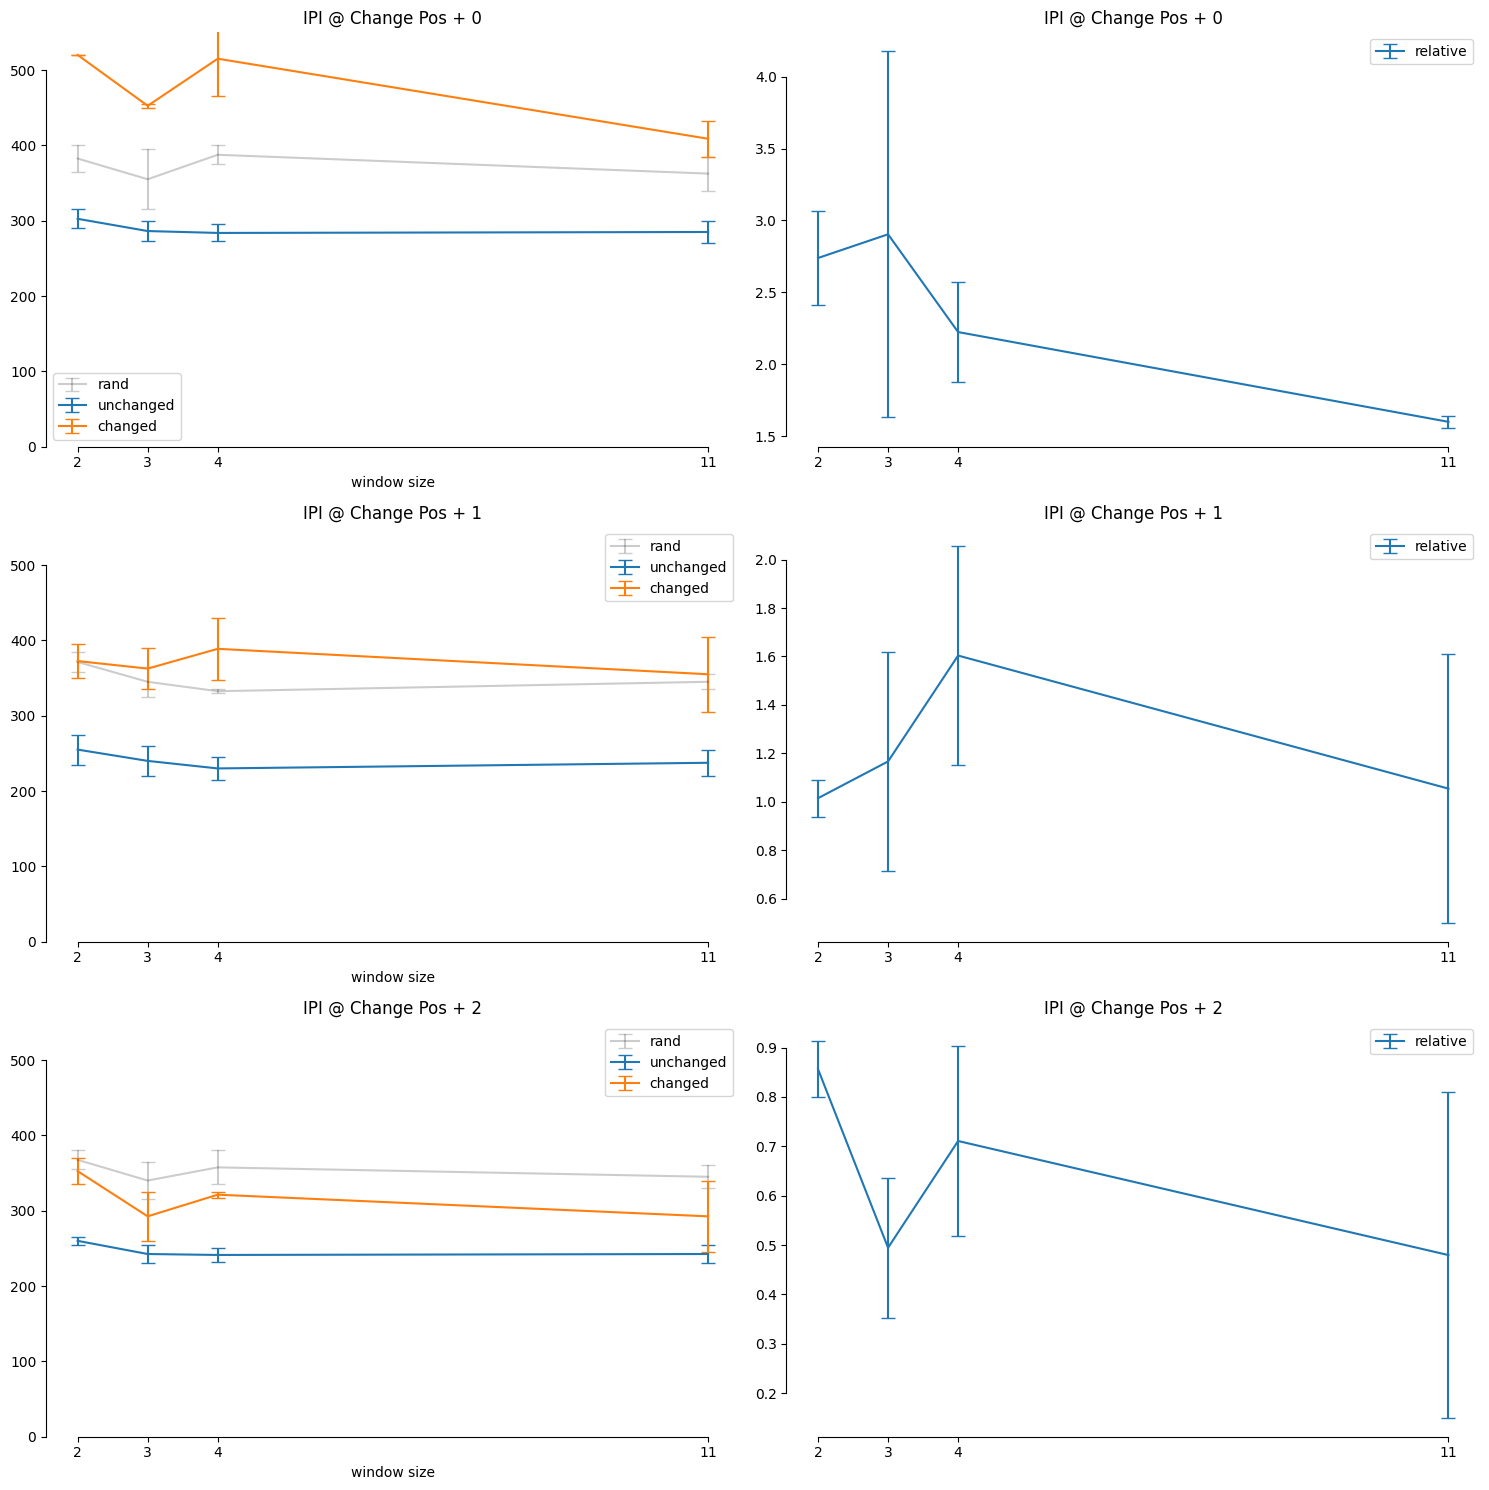

In [40]:
lookahead_window = 3

fig, axs = plt.subplots(nrows=lookahead_window, ncols=2 , figsize= (15,15))

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()


# test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

test_blocks = utils.remove_error_trials_presses(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for lookahead in range(lookahead_window):

    finger_aggs = {}

    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 + lookahead for pos in digit_change])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):
    # for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 + lookahead for pos in [4,6]])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[(data['digitChangePos'] + 1 + lookahead) == (data['N'])]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'windowSize']).agg({
        'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data
  
        data_agged = data.groupby('windowSize').agg({
            'IPI_Value': ['mean', 'sem']
        }).reset_index()

        axs[lookahead, 0].errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

        means = data_agged['IPI_Value']['mean']

        # for i in range(len(windowSizes) - 1):
        #     t_stat, p_value = stats.ttest_rel(
        #         data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
        #         data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        #     )
        #     if p_value < 0.05:
        #         # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
        #         axs[lookahead].text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
        #         # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


        axs[lookahead, 0].set_title(f'IPI @ Change Pos + {lookahead}')
        axs[lookahead, 0].set_xlabel('window size')
        axs[lookahead, 0].set_xticks(data_agged['windowSize'])
        axs[lookahead, 0].legend()
        axs[lookahead, 0].set_ylim([0, 550])

        # Combine all data into a single DataFrame
    combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                            finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])
    
    print(f"************************** IPI Change + {lookahead} **************************************")

    print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())



    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'windowSize'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'windowSize'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})
    merged_df['rel'] = (merged_df['IPI_Value_changed'] - merged_df['IPI_Value_unchanged'])/(merged_df['IPI_Value_rand'] - merged_df['IPI_Value_unchanged'])

    data_agged = merged_df.groupby('windowSize').agg({
            'rel': ['mean', 'sem']
        }).reset_index()
     
    axs[lookahead, 1].errorbar(data_agged['windowSize'], data_agged['rel']['mean'], yerr = data_agged['rel']['sem'], label = 'relative', capsize=5)
    axs[lookahead, 1].set_title(f'IPI @ Change Pos + {lookahead}')
    axs[lookahead, 1].set_xticks(data_agged['windowSize'])
    axs[lookahead, 1].legend()



sns.despine(fig, trim = True)
fig.tight_layout()
# plt.savefig(path_figs + "change_after_window_IPI.pdf", format = 'pdf')
plt.show()


rand
[2, 3, 4, 11]
[382.5, 355.0, 387.5, 362.5]
unchanged
[2, 3, 4, 11]
[302.5, 286.25, 283.75, 285.0]
changed
[2, 3, 4, 11]
[520.0, 452.5, 515.0, 408.75]
************************** IPI Change - 0 **************************************
All Three: 
                       Anova
                     F Value  Num DF Den DF Pr > F
--------------------------------------------------
condition            338.4208 2.0000 2.0000 0.0029
windowSize            15.1744 3.0000 3.0000 0.0256
condition:windowSize   2.5279 6.0000 6.0000 0.1419

unchanged_rand: 
                       Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition            68.0625 1.0000 1.0000 0.0768
windowSize            2.4907 3.0000 3.0000 0.2366
condition:windowSize  1.8067 3.0000 3.0000 0.3196

changed_unchanged: 
                       Anova
                     F Value  Num DF Den DF Pr > F
--------------------------------------------------
condition          

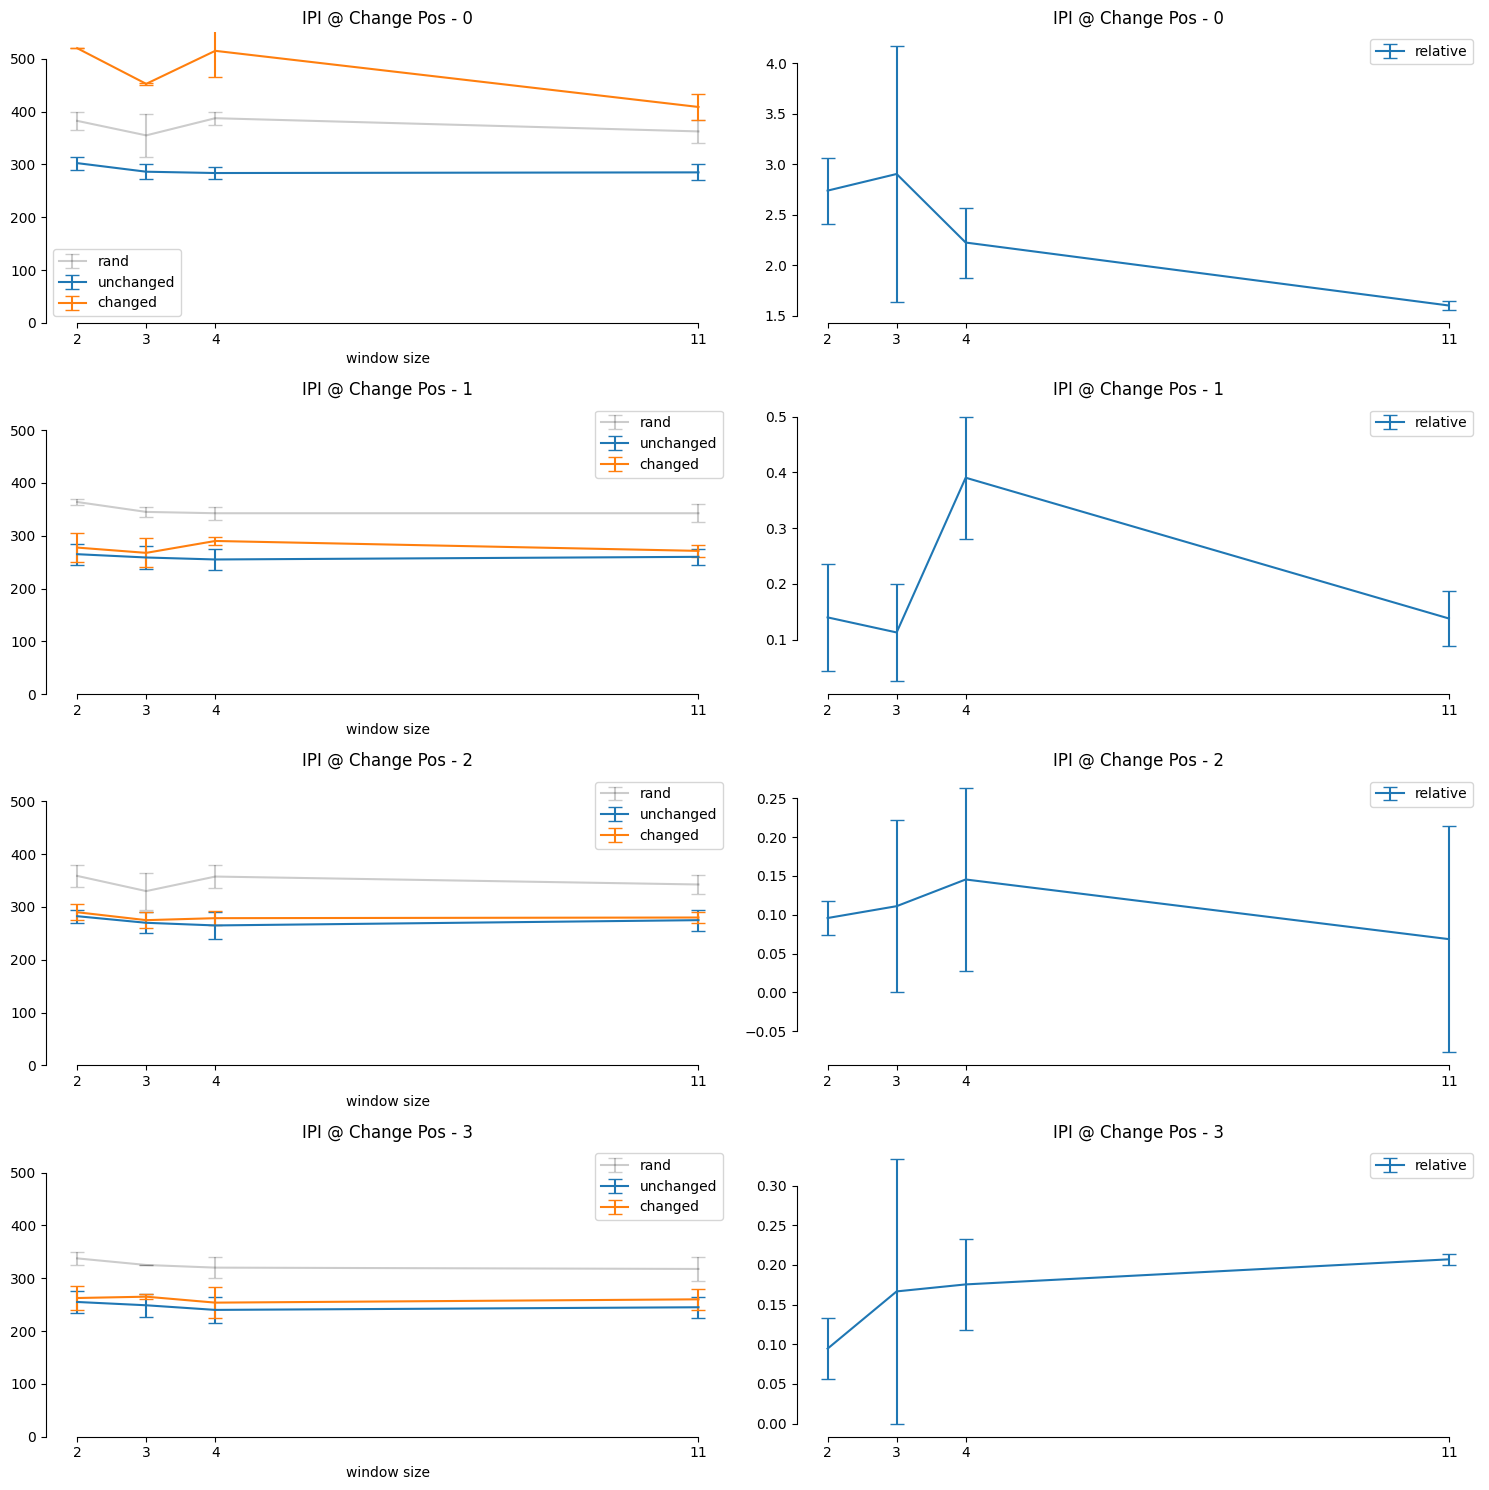

In [41]:
lookback_window = 4

fig, axs = plt.subplots(nrows=lookback_window, ncols=2 , figsize= (15,15))

test_blocks = subjs_presses[subjs_presses['BN'].isin(list(range(10,18)) + list(range(20,28)))].copy()

# test_blocks['IPI_Value'] = test_blocks.apply(utils.correct_error_trial_IPI, axis = 1)

test_blocks = utils.remove_error_trials_presses(test_blocks)

kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for lookback in range(lookback_window):

    finger_aggs = {}

    for _ ,((flag_trained, flag_rand, flag_change), data) in enumerate(test_blocks[test_blocks['N'].isin([pos + 1 - lookback for pos in digit_change])].groupby(['is_trained_seq', 'is_rand_seq', 'is_digit_changed'])):

        if (flag_trained & flag_change):
            data = data[(data['digitChangePos'] + 1) == (data['N'] + lookback)]
            label = 'changed'

        if(flag_trained & ~flag_change):
            label = 'unchanged'

        if (flag_rand):
            label = 'rand'

        data = data.groupby(['SubNum', 'windowSize']).agg({
        'IPI_Value': 'median'
        }).reset_index()

        finger_aggs[label] = data
  
        data_agged = data.groupby('windowSize').agg({
            'IPI_Value': ['mean', 'sem']
        }).reset_index()

        if(lookback == 0):
            print(label)
            print(list(data_agged['windowSize']))
            print(list(data_agged['IPI_Value']['mean']))

        axs[lookback, 0].errorbar(data_agged['windowSize'], data_agged['IPI_Value']['mean'], yerr = data_agged['IPI_Value']['sem'], label = label, capsize=5, **kwargs[label])

        means = data_agged['IPI_Value']['mean']

        # for i in range(len(windowSizes) - 1):
        #     t_stat, p_value = stats.ttest_rel(
        #         data[data['windowSize'] == windowSizes[i]]['IPI_Value'], 
        #         data[data['windowSize'] == windowSizes[i + 1]]['IPI_Value'], 

        #     )
        #     if p_value < 0.05:
        #         # plt.plot(windowSizes[i:i+2], means[i:i+2], color = 'black')
        #         axs[lookahead].text((windowSizes[i] + windowSizes[i + 1]) / 2, max(means[i], means[i + 1]) + 10, '*', color='black', ha='center')
        #         # plt.annotate(f'*', (windowSizes[i], data_agged['norm_MT']['mean'][i]), textcoords="offset points", xytext=(0, 10), ha='center')


        axs[lookback, 0].set_title(f'IPI @ Change Pos - {lookback}')
        axs[lookback, 0].set_xlabel('window size')
        axs[lookback, 0].set_xticks(data_agged['windowSize'])
        axs[lookback, 0].legend()
        axs[lookback, 0].set_ylim([0, 550])

        # Combine all data into a single DataFrame
    combined_data = pd.concat([finger_aggs['changed'].assign(condition='changed'),
                            finger_aggs['unchanged'].assign(condition='unchanged'),
                            finger_aggs['rand'].assign(condition='rand')])
    
    print(f"************************** IPI Change - {lookback} **************************************")

    print("All Three: \n", AnovaRM(data=combined_data, depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("unchanged_rand: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'rand'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())
    print("changed_unchanged: \n", AnovaRM(data=combined_data[combined_data['condition'].isin(['unchanged', 'changed'])], depvar='IPI_Value', subject='SubNum', within=['condition', 'windowSize']).fit())



    merged_df = finger_aggs['changed'].merge(finger_aggs['unchanged'], on = ['SubNum', 'windowSize'], suffixes=('_changed', '_unchanged'))
    merged_df = merged_df.merge(finger_aggs['rand'], on = ['SubNum', 'windowSize'])
    merged_df = merged_df.rename(columns={'IPI_Value': 'IPI_Value_rand'})
    merged_df['rel'] = (merged_df['IPI_Value_changed'] - merged_df['IPI_Value_unchanged'])/(merged_df['IPI_Value_rand'] - merged_df['IPI_Value_unchanged'])

    data_agged = merged_df.groupby('windowSize').agg({
            'rel': ['mean', 'sem']
        }).reset_index()
     
    axs[lookback, 1].errorbar(data_agged['windowSize'], data_agged['rel']['mean'], yerr = data_agged['rel']['sem'], label = 'relative', capsize=5)
    axs[lookback, 1].set_title(f'IPI @ Change Pos - {lookback}')
    axs[lookback, 1].set_xticks(data_agged['windowSize'])
    axs[lookback, 1].legend()



sns.despine(fig, trim = True)
fig.tight_layout()
# plt.savefig(path_figs + "Change_window_IPI.pdf", format = 'pdf')
plt.show()
